# PH SMK Test

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running a snakemake workflow.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from IPython.display import display
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt
import matplotlib

import ops
from ops.firesnake import Snake
from ops.imports_ipython import *
from ops.qc import *

## Helper Functions

In [2]:
# Function to generate file paths
def generate_file_paths(input_files_dir, preprocess_pattern, well, tile):
    image_paths = []
    
    # For PH, we typically have a single multichannel image per well/tile
    image_name = preprocess_pattern.format(well=well, tile=tile)
    image_path = f"{input_files_dir}/{image_name}"
    image_paths.append(image_path)
    
    return image_paths

# custom function to create segmentation colormap
def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation"""
    
    colmat = np.random.rand(num_colors,4)
    colmat[:,-1] = alpha
    colmat[0, :] = [0, 0, 0, 1]  # Set the first color to black with full transparency
    cmap = matplotlib.colors.ListedColormap(colmat)

    return cmap

## SET PARAMETERS

### Loading, aligning, detecting candiate reads

- `INPUT_FILES_DIR`: Directory for loading SBS image data and IC data
- `OUPUT_FILES_DIR`: Directory for saving outputs of this notebook 
- `PREPROCESS_PATTERN`: Pattern of file names resulting from preprocessing
- `WELLS` and `TILES`: The well and tile you want to analyze (for this notebook, we're using one well/tile combination for testing)
- `CHANNELS` and `PREPROCESS_PATTERN`: The channel names and file naming conventions
- `DISPLAY_RANGES` and `LUTS`: The display ranges and color schemes (Look-Up Tables) for your image data

In [3]:
# Directory for loading and saving files
INPUT_FILES_DIR = "input"
OUTPUT_FILES_DIR = "output/test"

# Define the file pattern
PREPROCESS_PATTERN = '20X_{well}_Tile-{tile}.phenotype.tif'

# Set wells and tiles (in this notebook, one well / tile combination to test on)
WELLS = "A1"
TILES = 1
WILDCARDS = dict(well=WELLS, tile=TILES)

# Define channels
CHANNELS = None

# Microplot information
DISPLAY_RANGES = [
    [500, 20000],
    [800, 5000],
    [800, 5000],
    [800, 5000]
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,    # Lookup table for DAPI channel
    ops.io.GREEN,   # Lookup table for CY3 channel
    ops.io.RED,     # Lookup table for A594 channel
    ops.io.MAGENTA, # Lookup table for CY5 channel
    ops.io.CYAN     # Lookup table for CY7 channel
]

In [4]:
print("Loading input images...")
input_image_paths = generate_file_paths(
    f"{INPUT_FILES_DIR}/ph_tifs", PREPROCESS_PATTERN, WELLS, TILES
)
input_image = read(input_image_paths[0])
print(f"Input image shape: {input_image.shape}")
# parse description from input image
description = parse(input_image_paths[0])
keys_to_remove = ["cycle", "tag", "file"]
for key in keys_to_remove:
    description.pop(key, None)
print(f"Input file description: {description}")

Loading input images...
Input image shape: (4, 2400, 2400)
Input file description: {'subdir': 'input/ph_tifs', 'mag': '20X', 'well': 'A1', 'tile': '1', 'ext': 'tif'}


## SET PARAMETERS

### Illumination correction and segmentation

- `IC_PREPROCESS_PATTERN`: Pattern of file names resulting from illumination correction preprocessing.
- `DAPI_INDEX`: The index of the DAPI channel in your image stack (0-indexed). Typically 0 for the DAPI channel from sequencing.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your image stack (0-indexed). Typically the channel that best outlines cell boundaries, usually base C.

In [5]:
# Define the ic file pattern
IC_PREPROCESS_PATTERN = f'20X_{WELLS}.phenotype.illumination_correction.tif'

# Define Cellpose segmentation parameters
DAPI_INDEX = 0
CYTO_CHANNEL = 1

Applying illumination correction to segmentation cycle image...
Example corrected image:


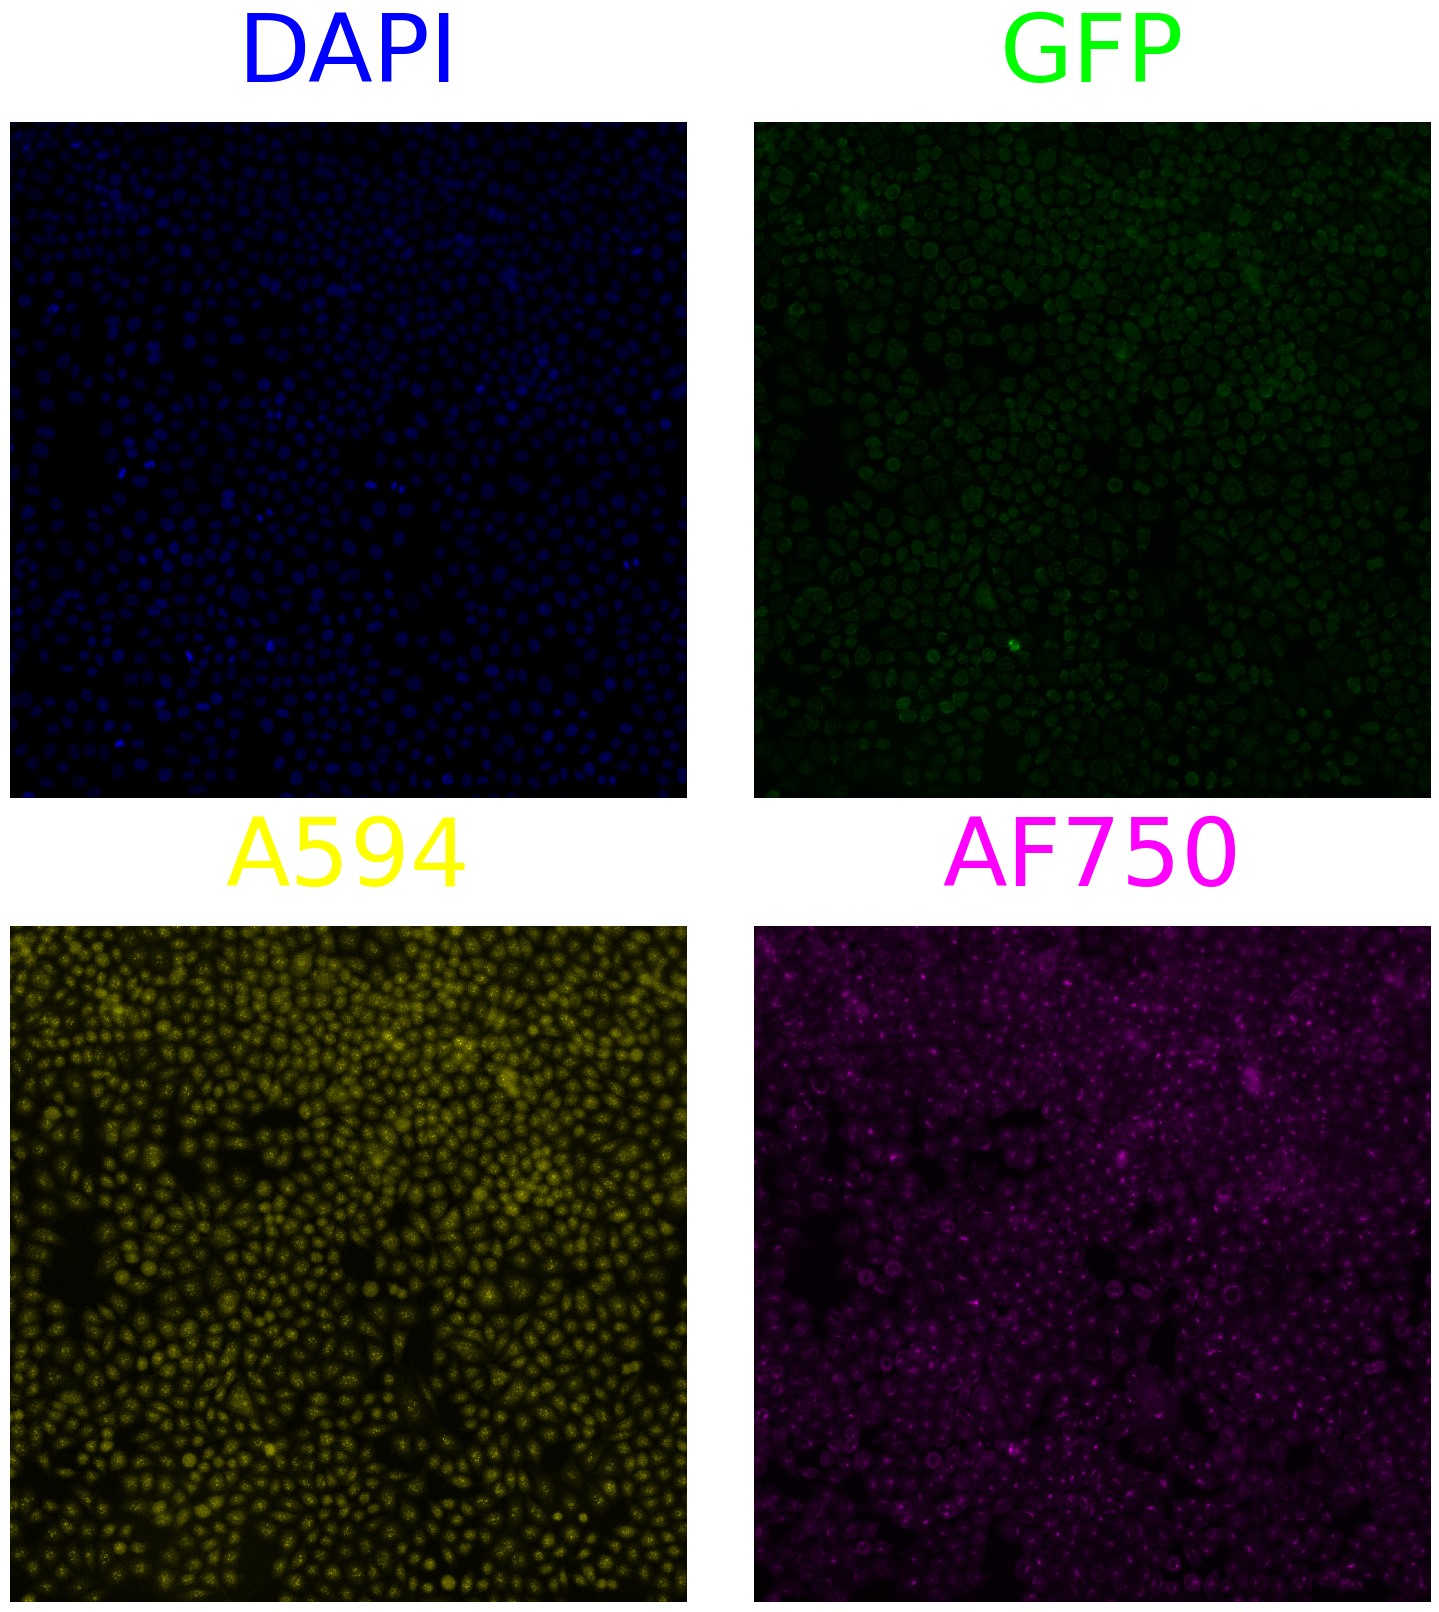

Preparing IC segmentation image for CellPose...


/opt/homebrew/anaconda3/envs/ops_dev/lib/python3.11/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


In [6]:
print("Applying illumination correction to segmentation cycle image...")
# Read the illumination correction file
icf_file_path = f"{INPUT_FILES_DIR}/ph_ic_tifs/{IC_PREPROCESS_PATTERN}".format(
    well=WELLS,
)
correction_image = read(icf_file_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = Snake._apply_illumination_correction(input_image, correction=correction_image)

# show corrected
print("Example corrected image:")
ph0_microshow = microplot.Microimage(corrected_image[0,:,:],
                                             cmaps = 'pure_blue',
                                             channel_names='DAPI')
ph1_microshow = microplot.Microimage(corrected_image[1,:,:],
                                             cmaps = 'pure_green',
                                             channel_names='GFP')
ph2_microshow = microplot.Microimage(corrected_image[2,:,:],
                                             cmaps = 'pure_yellow',
                                             channel_names='A594')
ph3_microshow = microplot.Microimage(corrected_image[3,:,:],
                                             cmaps = 'pure_magenta',
                                             channel_names='AF750')
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0,0], ph0_microshow)
panel.add_element([0,1], ph1_microshow)
panel.add_element([1,0], ph2_microshow)
panel.add_element([1,1], ph3_microshow)
panel.add_channel_label()
plt.show()

print("Preparing IC segmentation image for CellPose...")
cellpose_rgb = Snake._prepare_cellpose(corrected_image, DAPI_INDEX, CYTO_CHANNEL)
save(name(description, tag='prepared_cellpose', subdir=OUTPUT_FILES_DIR), cellpose_rgb)
# note, this process is done during the _segment_cellpose method below as well
# use the prepared_cellpose image to test CellPose (see below)

## SET PARAMETERS

### Illumination correction and segmentation

- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

For Cellpose segmentation, we strongly suggest calibrating via the Cellpose GUI. Follow these steps:

1. Open a terminal window
2. SSH onto fry: `ssh -Y username@fry.wi.mit.edu`
3. Activate a conda environment with cellpose[gui]: `conda activate ops_viewing`
4. Launch Cellpose: `python -m cellpose`
5. Open the prepared Cellpose image: `output/test/10X_well_Tile-nn.prepared_cellpose.tif`
6. Calibrate cyto3 model:
   - For cell diameter: use chan to segment = 2, chan2 = 3
   - For nuclei diameter: use chan to segment = 3, chan2 = 0

Note: You may want to adjust the diameter parameters and segment to test if you feel like you are capturing too little or too much area for either of the two masks.

In [7]:
# Parameters for cellpose method
NUCLEI_DIAMETER = 47.1  # Calibrate with CellPose
CELL_DIAMETER = 55.3  # Calibrate with CellPose
CYTO_MODEL = "cyto3"

In [8]:
nuclei, cells = Snake._segment_cellpose(
    data=corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_CHANNEL,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cyto_model=CYTO_MODEL
)
save(name(description, tag='nuclei', subdir=OUTPUT_FILES_DIR), nuclei, compress=1)
save(name(description, tag='cells', subdir=OUTPUT_FILES_DIR), cells, compress=1)

/opt/homebrew/anaconda3/envs/ops_dev/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filenam

removing edges


found 1170 nuclei before reconciling
found 1144 cells before reconciling


reconciling masks with method how=consensus


found 1126 nuclei/cells after reconciling


Number of nuclei segmented: 1126
Number of cells segmented: 1126


Example microplots for nuclei segmentation:


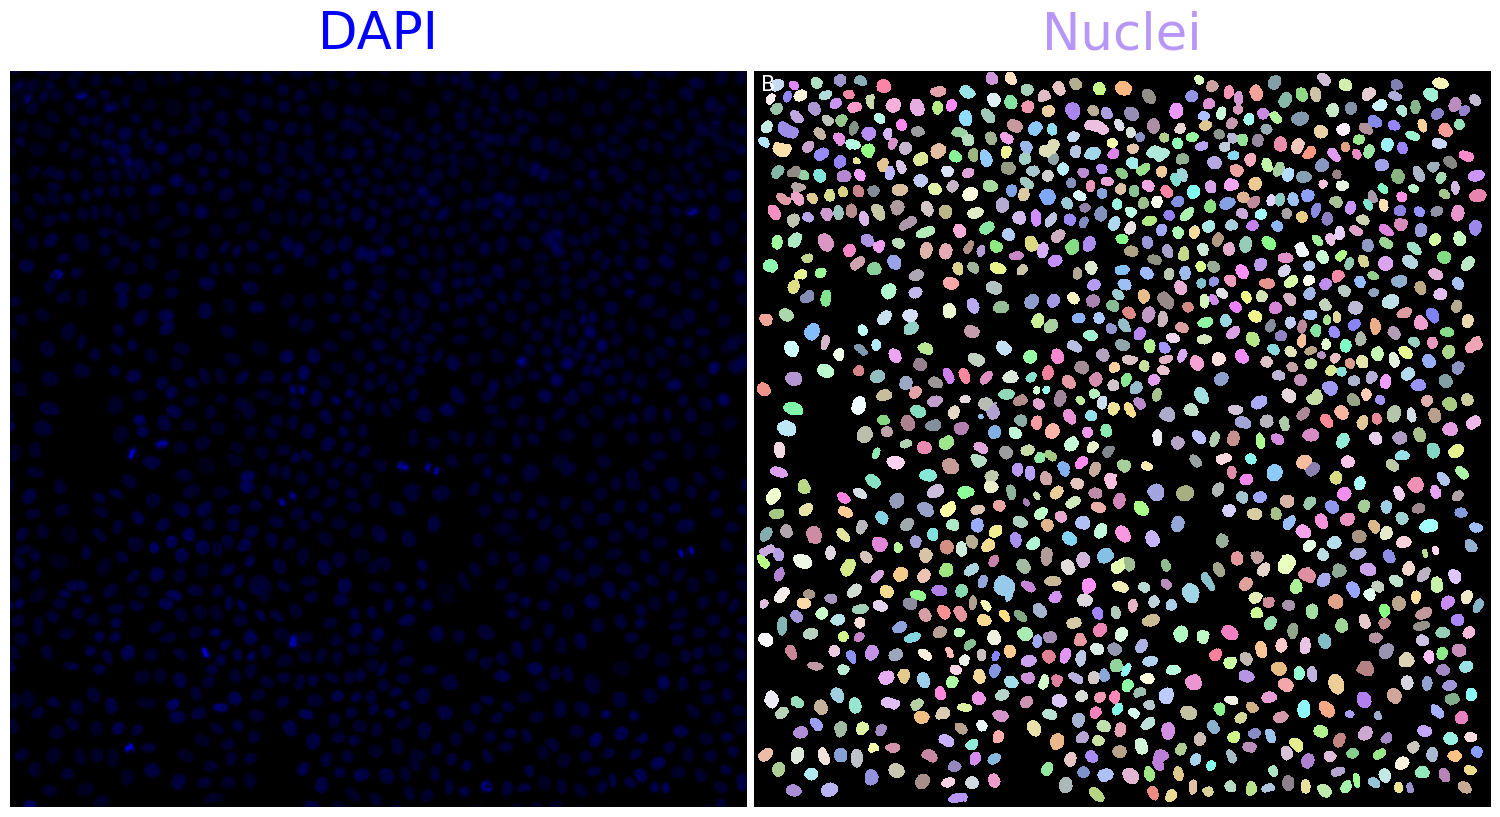

Example microplots for merged segmentation:


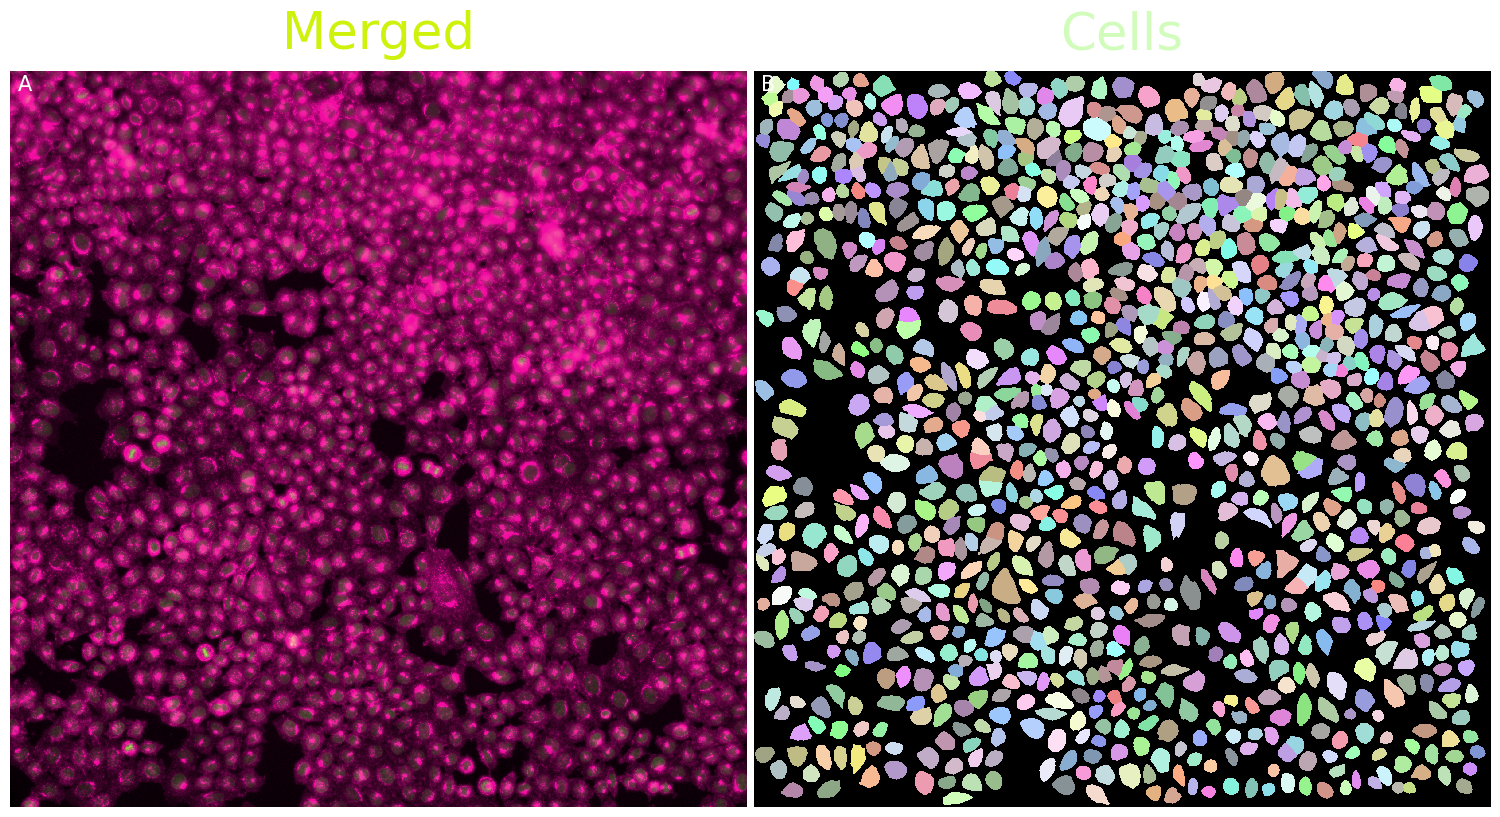

Annotating segmentation on phenotyping data...


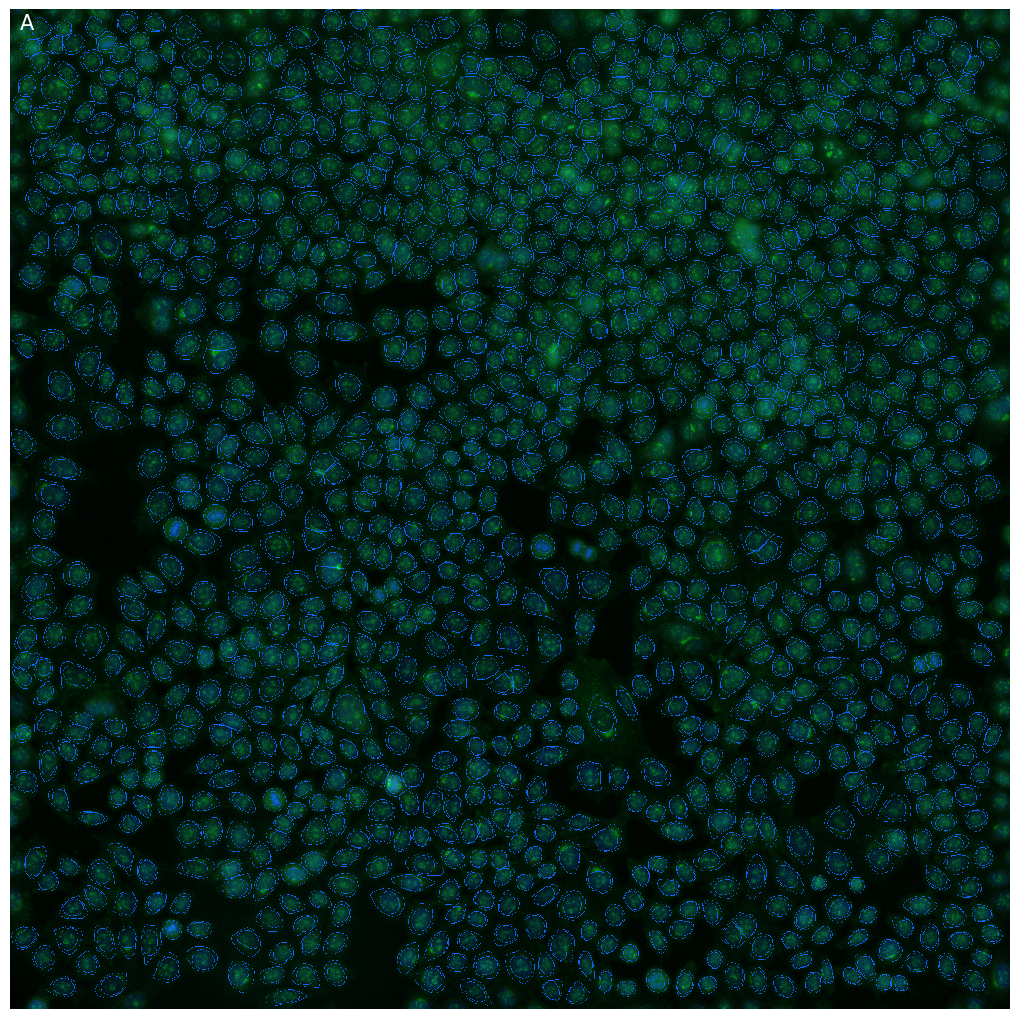

Example microplots for cytoplasms relative to nuclei
Number of cytoplasms identified: 1126


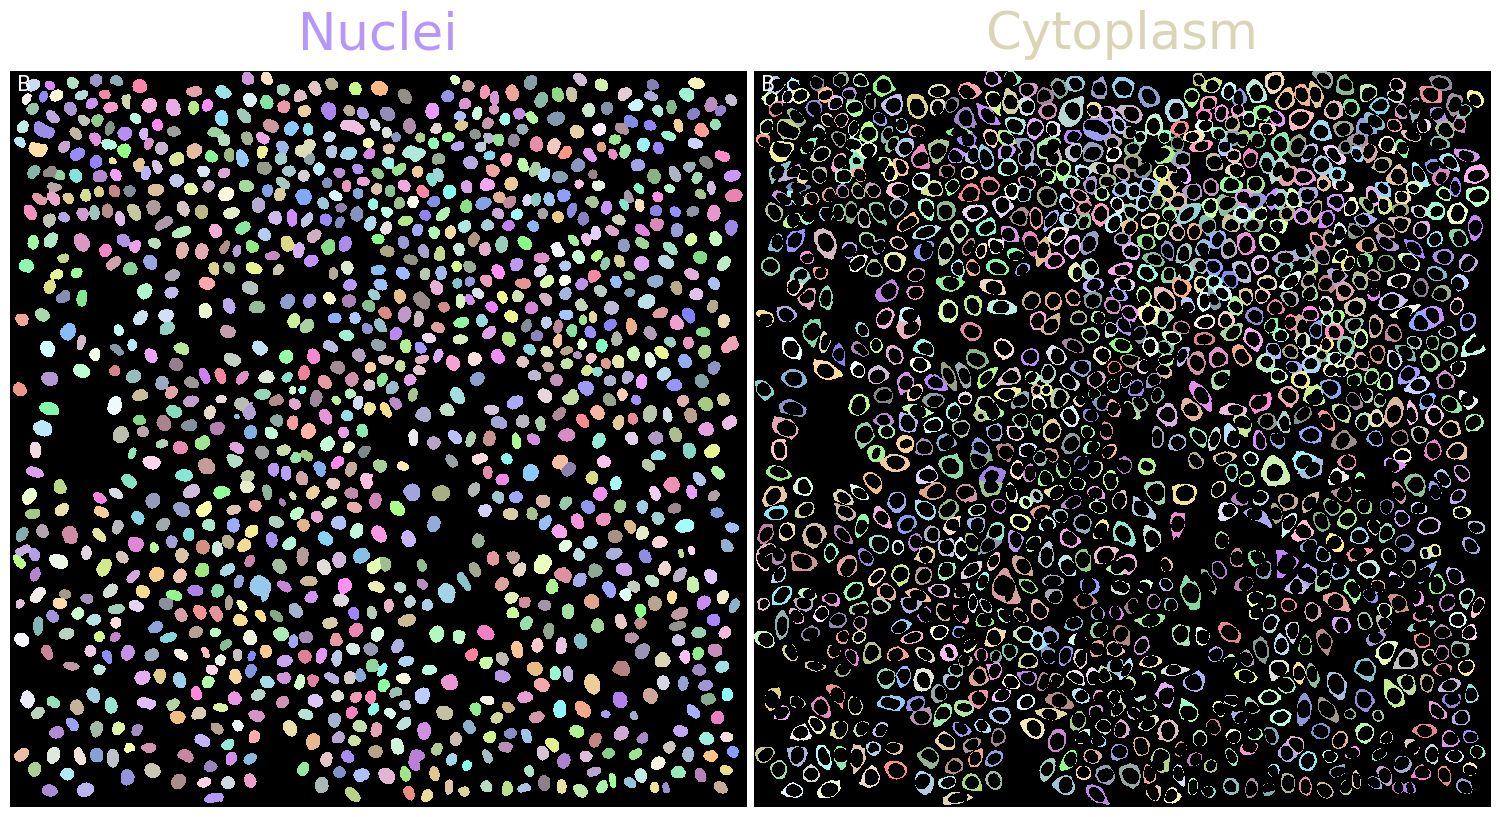

In [9]:
print("Example microplots for nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(nuclei, 
                                        label_text='B',
                                        cmaps = nuclei_cmap,
                                        channel_names='Nuclei')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], ph0_microshow)
panel.add_element([0,1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged segmentation:")
all_microshow = microplot.Microimage(corrected_image,
                                     rescale_type='limits', 
                                     limits=DISPLAY_RANGES,
                                     label_text='A',
                                     channel_names='Merged')

cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells,
                                       label_text='B',
                                       cmaps = cells_cmap,
                                       channel_names='Cells')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], all_microshow)
panel.add_element([0,1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Annotating segmentation on phenotyping data...")
annotated_data=Snake._annotate_on_phenotyping_data(corrected_image, nuclei, cells)
save(name(description, tag='segmentation', subdir=OUTPUT_FILES_DIR), annotated_data)
annotated_microshow = microplot.Microimage(annotated_data,
                                           label_text='A',
                                           channel_names='Merged')
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0,0], annotated_microshow)
plt.show()

print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = Snake._identify_cytoplasm_cellpose(nuclei, cells)
cytoplasm_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasm_microshow = microplot.Microimage(cytoplasms,
                                           label_text='B',
                                           cmaps = cytoplasm_cmap,
                                           channel_names='Cytoplasm')
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], nuclei_microshow)
panel.add_element([0,1], cytoplasm_microshow)
panel.add_channel_label()